In [ ]:
!pip install pytictoc

In [ ]:
import numpy as np
import pandas as pd
from pytictoc import TicToc
import time

### Trials data

In [ ]:
# trials data:
# 0: plane speed m/s
# 1: plane angular velocity - x m/s
# 2: plane angular velocity - y m/s
# 3: plane angular velocity - z m/s
# 4: plane initial position - x m
# 5: plane initial position - y m
# 6: plane initial position - z m
# 7: particle radius m
# 8: sprayer amplitude = 0 to 0.5
# 9: release time start s
# 10: release time end s --> 
# 11: drop rate of retardant m^3/s
# 12: particle drop velocity m/s
# 13: wind velocity - x m/s
# 14: wind velocity - y m/s
# 15: wind velocity - z m/s
# 16: max tank capacity - m^3

# Reference: https://drive.google.com/file/d/1hd6slnflk6E_wYNUCgcL1FqO7Svdr1-Y/view?usp=sharing
# Plane velocity converted from knots to m/s
# Plane altitude converted from ft to m
# Particle R assumed to be 0.01m
# Sprayer is gravity assist only
# Release end time = start time + volume/flow
# Drop rate (USE Calculated Average column) converted from gallon/s to m^3/s

debugging_trial = np.array([
    10, 0, 0, 0, 0, 0, 30, 0.1, 0, 0.10, 2.5, 30, 10, 0, 0, 0
    ]);

zero_wind_trials = np.array([
    #Trials to add:
    
    #Drop 13 --> coverage level 1
    [73.0511, 0, 0, 0, 0, 0, 59.7408, 0.05, 0.25, 0.25, 0.25+4683/369, 1.39682, 0, 0, 0, 0, 17.72708],

    #Drop 12 --> coverage level 2
    [73.5656, 0, 0, 0, 0, 0, 71.3232, 0.05, 0.25, 0.10, 0.10+4814/479, 1.81321, 0, 0, 0, 0, 18.22297],

    #Drop 11/14a --> coverage level 3
    [74.08, 0, 0, 0, 0, 0, 60.96, 0.05, 0.25, 0.20, 0.20+4779/840, 3.17975, 0, 0, 0, 0, 18.09048],
    
    #Drop 1 -->coverage level 4
    [79.2244, 0, 0, 0, 0, 0, 69.7992, 0.05, 0.25, 0.20, 0.20+9310/1120, 4.239661, 0, 0, 0, 0, 35.24218],
    
    #Drop 8 --> coverage level 5,6,7,8
    [80.7678, 0, 0, 0, 0, 0, 75.8952, 0.05, 0.25, 0.20, 0.20+9286/2063, 7.809305, 0, 0, 0, 0, 35.15133],
    ]);

wind_speeds = [
    [0,0,0],
    [0,10,0],
    [0,20,0],
    [0,30,0],
    [0,40,0],
    [0,50,0]
]

In [ ]:
def normalize(vec):
    length=np.sqrt(np.sum(vec**2))
    if length == 0:
        return 0;
    else:
        return vec/length;
    
def norm(vec):
    return np.sqrt(np.sum(vec**2))

### Genetic Algorithm

In [ ]:
def SimDrop_GA(S, G, P, K, numelString, trial):
# Genetic Algorithm variables:
# S : Number of genetic strings per generation
# G : Number of generations to optimize the string
# P : Number of parents combined to create children
# K : Number of children produced (K = P) -> we can eliminate it
# numelString : Number of elements per string (number of variables to optimize)

# trials data:
# *0: plane speed m/s
# 1: plane angular velocity - x m/s
# 2: plane angular velocity - y m/s
# 3: plane angular velocity - z m/s
# *4: plane initial position - x m
# *5: plane initial position - y m
# *6: plane initial position - z m
# 7: particle radius m
# 8: sprayer amplitude = 0
# 9: release time start s
# 10: release time end s
# *11: drop rate of retardant m^3/s
# 12: particle drop velocity m/s
# 13: wind velocity - x m/s
# 14: wind velocity - y m/s
# 15: wind velocity - z m/s
# 16: total volume - m^3

# Variables of the problem to optimize
# *V_plane : the plane's velocity (magnitude)
# angular_velocity_plane : the plane's angular velocity (three component)
# *r_plane : the initial plane position (three component vector)
# R_particle : radius of the particles
# A : the sprayer amplitude
# Ti : the release time start (percentage)
# Tf : the release time end (percentage)
# *drop_rate : the drop rate of retardant
# V_particle_drop : the particle drop velocity

# Genetic Algorithm
# Initialization of parameters
    Min=np.repeat(-1,G);
    #Ave=zeros(G,1); #Can eliminate
    
    trial_data = trial;

    # STEP 1: Randomly generation of the initial population of S strings (optional: introduce all limits as variables)
    V_plane = (103 - 73) * np.random.uniform(size=S) + 73;
    r_plane_1 = (100 - (-50)) * np.random.uniform(size=S) + (-50);
    r_plane_2 = (50 - (-50)) * np.random.uniform(size=S) + (-50);
    r_plane_3 = (94 - 45) * np.random.uniform(size=S) + 45;
    drop_rate = (7.8 - 1.3) * np.random.uniform(size=S) + 1.3;
    Pi = np.repeat(-1,S);

    Lam=np.transpose([V_plane, r_plane_1, r_plane_2, r_plane_3, drop_rate, Pi]);


    for j in range(0,G):
        print("Generation ", j)
        # Step 2: Compute the "fitness" of each string: cost function value
        for i in range(0,S):
            trial_data[0] = Lam[i,0];
            trial_data[4] = Lam[i,1];
            trial_data[5] = Lam[i,2];
            trial_data[6] = Lam[i,3];
            trial_data[11] = Lam[i,4];
            
            #update simulation finish time based on max capacity of tank
            trial_data[10] = trial_data[9] + trial_data[16] / trial_data[11]
            
            Lam[i,5] = Simulation(trial)[0];

        # Step 3: Rank the genetic strings
        Lam=Lam[np.argsort(Lam[:,5])];
        print("Minimum PI value is ", Lam[0:5])

        # Step 4: Make the top pairs and generate children
        phi=np.random.uniform(size=(K,numelString));

        ind1=np.arange(0,K,2);
        ind2=np.arange(1,K,2);

        Lam[P:P+K,0:5] = [phi[ind1]*Lam[ind1,0:5]+(1-phi[ind1])*Lam[ind2,0:5],
                          phi[ind2]*Lam[ind2,0:5]+(1-phi[ind2])*Lam[ind1,0:5]]
        
        #Reset scores to -1
        Lam[P:P+K,5] = -1

        #Lam=horzcat(Lam(:,1:P), phi(ind1).*Lam(:,ind1)+(1-phi(ind1)).*Lam(:,ind2), phi(ind2).*Lam(:,ind2)+(1-phi(ind2)).*Lam(:,ind1));

        # Step 5: Randomly generation of S-K-K new strings
        V_plane = (103 - 73) * np.random.uniform(size=S-2*P) + 73;
        r_plane_1 = (100 - (-50)) * np.random.uniform(size=S-2*P) + (-50);
        r_plane_2 = (50 - (-50)) * np.random.uniform(size=S-2*P) + (-50);
        r_plane_3 = (94 - 45) * np.random.uniform(size=S-2*P) + 45;
        drop_rate = (7.8 - 1.3) * np.random.uniform(size=S-2*P) + 1.3;
        Pi = np.repeat(-1,S-2*P);

        Lam[P+K:,] = np.transpose([V_plane, r_plane_1, r_plane_2, r_plane_3, drop_rate, Pi]);

        Min[j]=Lam[0,5]
        #Ave(j)=mean(Pi);

    trial_data[0] = Lam[0,0];
    trial_data[4] = Lam[0,1];
    trial_data[5] = Lam[0,2];
    trial_data[6] = Lam[0,3];
    trial_data[11] = Lam[0,4];

    #[Pi_optimized] = SimDrop (trial);

    return [Lam[0,5], np.mean(Lam[:,5]), Lam[0,:]];

### Class Plane

In [ ]:
class Plane:
    def __init__(self, r, dr, v, w, simTime, dt):
        #self.m;    # mass [kg]
        self.t=0.0;    # time
        self.dt=dt;   # time step size   [s]
        self.tf=simTime;   # final time       [s]
        #self.w;    # drone ang. vel.  [p, q, r]
        self.r=np.array(r);    # position vector  [X-pos, Y-pos, Z-pos]
        self.dr=np.array(v*dr);   # velocity vector  [dX, dY, dZ]
        self.dr_unit=self.normalize(dr); #unit vector of the velocity
        
        #self.wMat; 
        
        self.wing = np.cross(self.dr_unit, [0, 0, 1]);
        
        self.body = np.array([
            [self.r[0],                              self.r[1],                               self.r[2]],   # Center of vehicle
            [20*self.wing[0]+self.r[0],                    20*self.wing[1]+self.r[1],                    20*self.wing[2]+self.r[2]],   # Right Arm
            [5*self.dr_unit[0]+self.r[0],              5*self.dr_unit[1]+self.r[1],              5*self.dr_unit[2]+self.r[2]],   # Front Sprayer [2]
            [-20*self.dr_unit[0]+self.r[0],            -20*self.dr_unit[1]+self.r[1],            -20*self.dr_unit[2]+self.r[2]],   # Tail
            [-5*self.wing[0]-20*self.dr_unit[0]+self.r[0],  -5*self.wing[1]-20*self.dr_unit[1]+self.r[1],  -5*self.wing[2]-20*self.dr_unit[2]+self.r[2]],   # Left Tailtip
            [5*self.wing[0]-20*self.dr_unit[0]+self.r[0],   5*self.wing[1]-20*self.dr_unit[1]+self.r[1],    5*self.wing[2]-20*self.dr_unit[2]+self.r[2]],   # Right Tailtip
            [-10*self.dr_unit[0]+self.r[0],            -10*self.dr_unit[1]+self.r[1],            -10*self.dr_unit[2]+self.r[2]],   # Mid Center-tail
            [-20*self.wing[0]+self.r[0],                   -20*self.wing[1]+self.r[1],                   -20*self.wing[2]+self.r[2]],   # Left Arm
            [-5*self.dr_unit[0]+self.r[0],              -5*self.dr_unit[1]+self.r[1],              -5*self.dr_unit[2]+self.r[2]],   # Back Sprayer (8)
            [10*self.dr_unit[0]+self.r[0],             10*self.dr_unit[1]+self.r[1],             10*self.dr_unit[2]+self.r[2]],   # Front
            [0*self.dr_unit[0]+self.r[0],              0*self.dr_unit[1]+self.r[1],              0*self.dr_unit[2]+self.r[2]]    # Center Sprayer (10]
        ]);
        #self.wMat = repmat(self.w,1,np.shape(self.body,2);
            
        self.normal = self.normalize(np.cross(self.dr, (self.body[5] - self.body[4])));
    
    def normalize(self, vec):
        length=np.sqrt(np.sum(vec**2))
        if length == 0:
            return 0;
        else:
            return vec/length
        
    def UpdateState(self):
        # Update position of the plane
        self.t = self.t + self.dt;
            
        #IGNORING ANGULAR VELOCITY CALCULATIONS    
        #wXr = np.cross(self.wMat, self.body);
        #self.body = self.body + (self.dr + wXr)*self.dt;
        self.body = self.body + (self.dr)*self.dt;
        #Update normal vector to the plane
        self.normal = self.normalize(np.cross(self.dr, (self.body[5] - self.body[4])));
            
    def GetBody(self):  # Getter function for state variable
        return self.body;

    def GetTime(self):  # Getter function for time variable
        return self.t;

### ParticleMotion

In [ ]:
class Particles:
    # Inputs:
        # dt: time step
        # v_f: velocity of the air (3x1 vector)
        # v_release: 
        # R_p: radius of the particle
        # rho_p: density of the particle
        # rho_a: desity of the air
        # mu_f: viscosity coefficient of air
        
        # r_p: initial position of particle (3x1 vector)
        # v_p: initial velocity of particle (3x1 vector)
    def __init__(self, Npp, Nts, Nspray, v_f, v_release, amp, dt, radius, rho_p, rho_a, mu_f):
        
        #idx = pd.MultiIndex.from_product([np.arange(1,Nts+1),np.range(1,Nspray+1)]);
        self.r_p = pd.DataFrame(np.nan, index=np.arange(0,Npp*Nts*Nspray), columns=['x','y','z','t','sprayer']);
        self.v_p = pd.DataFrame(np.nan, index=np.arange(0,Npp*Nts*Nspray), columns=['x','y','z','t','sprayer']);
        
        self.Npp = Npp;
        self.Nts = Nts;
        self.Nspray = Nspray;
        self.v_f = np.array(v_f);
        self.v_release = np.array(v_release);
        self.amp = amp;
        self.radius = radius;
        self.rho_p = rho_p;
        self.rho_a = rho_a;
        self.mu_f = mu_f;
        
        self.A_p=np.pi*(self.radius**2);
        self.m_p=self.rho_p*(4/3)*np.pi*(self.radius**3);

        self.F_grav = self.m_p*np.array([0, 0, -9.815]);
        
        self.dt = dt;
    
def SetParticlePosition(particles,plane,t_index):
    front=np.append(plane.body[2],[t_index,1]);
    center=np.append(plane.body[10],[t_index,2]);
    back=np.append(plane.body[8],[t_index,3]);
    
    return np.repeat([front,center,back],particles.Npp,axis=0)

def SetParticleVelocity(particles,plane):
    #CHANGE RANDOMNESS TO LIMIT ANGLE BETWEEN 0 and 180
    #INTRODUCE RANDOMNESS TO THE DROP SPEED (0.01 - 0.5)
    #nrand = np.random.uniform(low=0,high=1,size=(particles.Npp*3,3))
    #for i in nrand:
    #    i = norm(i);
    #n_spray=(plane.normal + particle.amp*nrand)/ vecnorm((plane.normal'+A*nrand)')';
    #v_released*n_spray;
    #min_idx = int((t_index - 1)*particles.Npp*particles.Nspray);
    #max_idx = int(t_index*particles.Npp*particles.Nspray - 1);
        
    rand_velocity = np.random.uniform(low=-0.5,high=-0.1,size=(particles.Npp*particles.Nspray,3));
    particles.v_p.loc[min_idx:max_idx,['x','y','z']]=(plane.dr + rand_velocity);
    particles.v_p.loc[min_idx:max_idx,['t']]=t_index;
    particles.v_p.loc[min_idx:max_idx,'sprayer']=np.transpose(np.repeat([1,2,3],particles.Npp,axis=0));

def GetDragCoef(particles,v_diff):
    # Reynolds number
    Re=(2*particles.radius*particles.rho_a*norm(v_diff))/particles.mu_f;
    CD = -1;

    # Piecewise relation for the drag coefficient CD
    if Re<=1:
        return 24/Re;
    else:
        if Re<=400:
            return 24/(Re**0.646);
        else:
            if Re<=3*(10**5):
                return 0.5;
            else:
                if Re<=2*(10**6):
                    return 0.000366*(Re**0.4275);
                else:
                    return 0.18;

def UpdateVelocity(x,y,z,particles):
    v_part = np.array([x,y,z]);
    v_diff = particles.v_f-v_part;
    F_drag = (1/2)*particles.rho_a*GetDragCoef(particles,v_diff)*norm(v_diff)*(v_diff)*particles.A_p;
    update = v_part + (particles.dt/particles.m_p)*(particles.F_grav + F_drag)
    return update;

def UpdatePosition(particles,t_index):
    #HOW DO WE APPLY ONLY TO PARTICLES THAT ARE NOT ON THE GROUND???
    max_idx = (t_index - 1)*particles.Npp*particles.Nspray;
    particles.r_p.loc[:max_idx,'x'] = particles.r_p.loc[:max_idx,'x'] + particles.dt*particles.v_p.loc[:max_idx,'x'];
    particles.r_p.loc[:max_idx,'y'] = particles.r_p.loc[:max_idx,'y'] + particles.dt*particles.v_p.loc[:max_idx,'y'];
    particles.r_p.loc[:max_idx,'z'] = particles.r_p.loc[:max_idx,'z'] + particles.dt*particles.v_p.loc[:max_idx,'z'];

    # TEST AND INTEGRATE THIS SECTION OF THE CODE
    # if r_pnew(3) < 0
    #     u = (r_pnew-r_p);
    #     r_pnew(1) = r_p(1) - (u(1)/u(3))*r_p(3);
    #     r_pnew(2) = r_p(2) - (u(2)/u(3))*r_p(3);
    #     r_pnew(3) = 0;
    # else

def MarkHitTargets(x,y,z,p,p_hit):
    TOL=5
    hits = p.r_p[((p.r_p['x']-x)**2+(p.r_p['y']-y)**2+(p.r_p['z']-z)**2)**0.5 <= TOL];
    p_hit[hits.index.tolist()] = 1
    count = hits.shape[0]
    if (count>0):
        return 1;
    else:
        return 0;
    
#def MarkHitParticles(x,y,z,r_t,p_hit):
#    TOL=5
#    count = r_t[((r_t['x']-x)**2+(r_t['y']-y)**2+(r_t['z']-z)**2)**0.5 <= TOL].shape[0]
#    if (count>0):
#        return 1;
#    else:
#        return 0;
#    return 0;

### Controller Function

In [ ]:
def Controller(trial, optimize):
    if optimize:
        #call Genetic Algorithm function
        ## Optimize the problem
        # S : Number of genetic strings per generation
        # G : Number of generations to optimize the string
        # P : Number of parents combined to create children --> MAKE SURE THAT THIS IS AN EVEN NUMBER
        # K : Number of children produced (K = P) -> we can eliminate it
        # numelString : Number of elements per string (number of variables to optimize) --> DO NOT CHANGE
        S = 6;
        G = 40;
        P = 2;
        K = P;
        numelString = 5;
        optimized = SimDrop_GA(S, G, P, K, numelString, trial);
    else:
        #Call simulation function directly
        Simulation(trial);
    
    return optimized

### Simulation

In [ ]:
def Simulation(trial):
    # trial: 
    # 0: plane speed m/s
    # 1: plane angular velocity - x m/s
    # 2: plane angular velocity - y m/s
    # 3: plane angular velocity - z m/s
    # 4: plane initial position - x m
    # 5: plane initial position - y m
    # 6: plane initial position - z m
    # 7: particle radius m
    # 8: sprayer amplitude = 0
    # 9: release time start s
    # 10: release time end s
    # 11: drop rate of retardant m^3/s
    # 12: particle drop velocity m/s
    # 13: wind velocity - x m/s
    # 14: wind velocity - y m/s
    # 15: wind velocity - z m/s
    # 16: max tank capacity - m^3
    
    start = time.time()
    
    # Time variables
    T_I=round(trial[9],2);
    T_F=round(trial[10]);
    T=round(T_F*1.5);
    dt=trial[9];
    Nts=round((T_F-T_I)/dt); #Number of time steps where the particles are released
    offset = T_I/dt - 1;
    
    #print("T_I: ", T_I)
    #print("T_F: ", T_F)
    #print("T: ", T)
    #print("Nts: ", Nts)
    #print("T_I/dt: ", T_I/dt)
    #print("offset: ", offset)
    
    
    # Environment
    v_f=[trial[13], trial[14], trial[15]];
    rho_a=1.225;
    mu_f=0.000018;

    # Aircraft
    r=[trial[4], trial[5], trial[6]];
    v = trial[0];
    dr = np.array([1, 0, 0]);

    Drop_rate=trial[11];

    # What's the difference between A (sprayer amplitude) and v_released?
    amp=trial[8]; #Sprayer amplitude
    v_release=30;

    w=[trial[1],trial[2],trial[3]];

    # Particle
    rho_p=1077;
    radius=trial[7];

    V_p=Drop_rate*(T_F-T_I); #Opt
    N_p=V_p/((4/3)*np.pi*(radius**3));
    
    Nspray = 3;
    Npp=round(N_p/(Nspray*Nts));
    
    
    plane = Plane(r, dr, v, w, T, dt);
    particles = Particles(Npp, Nts, Nspray, v_f, v_release, amp, dt, radius, rho_p, rho_a, mu_f)
    
    print("Num of particles: ", particles.r_p.shape[0])
    
    targets_per_column = 100;
    num_columns = 5;
    targets_pos = np.transpose(np.array([
        np.repeat(np.linspace(0,2000,targets_per_column),num_columns),
        np.tile(np.linspace(-10,10,num_columns),targets_per_column),
        np.repeat(0,targets_per_column*num_columns),
        np.repeat(0,targets_per_column*num_columns)
    ]));
    #targets
    r_t = pd.DataFrame(data=targets_pos, index=np.arange(0,targets_per_column*num_columns), columns=['x','y','z','hit'])    
    
    #data structure to track which particles were hit
    p_hit = np.zeros(particles.r_p.shape[0])
    
    ti = TicToc()
    ti.tic()
    #for t in range(1,10):
    for t in range(1,int(T/dt)+1):
        t_upper = min((t-offset+1),(np.round((T_F-T_I)/dt,0)+1));
        
        if (t>=T_I/dt) & (t<T_F/dt):
            
            #t_index goes from 1...max
            min_idx = int((t-offset - 1)*particles.Npp*particles.Nspray);
            max_idx = int((t-offset)*particles.Npp*particles.Nspray - 1);
            
            #print("min_idx: ", min_idx)
            #print("max_idx", max_idx)
            
            front=np.append(plane.body[2],[t_upper,1]);
            center=np.append(plane.body[10],[t_upper,2]);
            back=np.append(plane.body[8],[t_upper,3]);
            
            particles.r_p.loc[min_idx:max_idx] = np.repeat([front,center,back],particles.Npp,axis=0)
            
            #SetParticleVelocity
            #split into x,y,z --> have different ranges for each direction
            #x --> -0.5 - 0.5
            #y --> -1 to 1
            #z --> -0.5 to -0.1
            rand_velocity = np.random.uniform(low=-0.5,high=-0.1,size=(particles.Npp*particles.Nspray,3))
            particles.v_p.loc[min_idx:max_idx,['x','y','z']]=(plane.dr + rand_velocity)
            particles.v_p.loc[min_idx:max_idx,['t']]=t_upper
            particles.v_p.loc[min_idx:max_idx,'sprayer']=np.transpose(np.repeat([1,2,3],particles.Npp,axis=0))
        
        
        #Set velocity of all particles on ground to zero
        if (t>=T_I/dt+1):
            
            particles.v_p.loc[particles.r_p['z']<=0,['x','y','z']] = [0,0,0];

            #For all above ground particles from previous time indexes, update velocity
            #dp_data_df['A'], dp_data_df['P'], dp_data_df['Y']
            
            #print("Num of moving particles: ", particles.v_p.loc[(particles.r_p['z']>0) & (particles.r_p['t']<t_upper),'x'].shape[0])
            
            try:
                particles.v_p.loc[(particles.r_p['z']>0) & (particles.r_p['t']<t_upper),'x'], particles.v_p.loc[(particles.r_p['z']>0) & (particles.r_p['t']<t_upper),'y'], particles.v_p.loc[(particles.r_p['z']>0)  & (particles.r_p['t']<t_upper),'z']= zip(
                    *particles.v_p[(particles.r_p['z']>0) & (particles.r_p['t']<t_upper)].apply(
                    lambda row: UpdateVelocity(row['x'],row['y'],row['z'],particles), axis=1));
            except ValueError:
                print("Likely no more particles left to fall")
                break;
            
                    
            UpdatePosition(particles,t_upper);
               
        
        plane.UpdateState();
    
    
    #Indicate which targets were hit by the particles
    r_t['hit'] = r_t.apply(lambda row: MarkHitTargets(row['x'],row['y'],row['z'],particles,p_hit),axis=1)
    
    #Indicate which particles hit targets
    #p_hit = particles.r_p.apply(lambda row: MarkHitParticles(row['x'],row['y'],row['z'],r_t),axis=1)
    print(np.sum(p_hit))
    print(p_hit.shape[0])
    score = (1 - r_t[r_t['hit']==1]['hit'].sum() / r_t.shape[0]) + (
        1 - np.sum(p_hit) / p_hit.shape[0]);
    
    ti.toc()
    end = time.time()
    runtime = (end - start)
    return [score, particles.r_p, particles.v_p, r_t, p_hit, plane, runtime];

## Simulation Code Samples

In [ ]:
#Run a single run of the simulation
results = Simulation(zero_wind_trials[0])

17.809455
1.39682
13
0.25
0.05
Num of particles:  33966
Likely no more particles left to fall
14742.0
33966
Elapsed time is 30.547153 seconds.


[1.3859777424483308,                  x         y          z     t  sprayer
 0       233.379877 -0.441091  -1.663027   2.0      1.0
 1       233.862478 -1.374199  -2.127342   2.0      1.0
 2       233.115006 -1.086074  -2.325084   2.0      1.0
 3       234.081162 -0.354098  -2.087516   2.0      1.0
 4       234.048367 -1.354815  -1.218745   2.0      1.0
 ...            ...       ...        ...   ...      ...
 33961  1163.149241 -1.409487  59.276644  52.0      3.0
 33962  1162.615868 -0.823834  59.133814  52.0      3.0
 33963  1163.430030 -1.552235  58.570243  52.0      3.0
 33964  1162.890109 -1.452703  58.970318  52.0      3.0
 33965  1162.588066 -0.636584  59.139164  52.0      3.0
 
 [33966 rows x 5 columns],                x         y         z     t  sprayer
 0       0.000000  0.000000  0.000000   2.0      1.0
 1       0.000000  0.000000  0.000000   2.0      1.0
 2       0.000000  0.000000  0.000000   2.0      1.0
 3       0.000000  0.000000  0.000000   2.0      1.0
 4       0.0000

In [ ]:
## EXAMPLE OF HOW TO UPDATE WINDSPEED FOR A TRIAL
copy = zero_wind_trials[-2]
copy[13:16] = wind_speeds[3]
print(copy)

[7.922440e+01 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 6.979920e+01 5.000000e-02 2.500000e-01 2.000000e-01
 8.512500e+00 4.239661e+00 0.000000e+00 0.000000e+00 3.000000e+01
 0.000000e+00 3.524218e+01]


In [ ]:
## Run a Genetic Algorithm trial for the trial with the modified windspeed
results = Controller(copy,True)
## Print the optimized parameters + score from the results
print(results[2])

# Documentation for optimized parameters array:
# 0 --> ground speed
# 1 --> starting x position
# 2 --> starting y position
# 3 --> starting z position
# 4 --> drop rate
# 5 --> cost score (ranges from 0 - 2)

In [ ]:
#Get starting location of plane
copy[4:7]

array([ 0.    ,  0.    , 69.7992])

## Visualization

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
results2 = Simulation(copy)

Num of particles:  71280
Likely no more particles left to fall
15642.0
71280
Elapsed time is 82.455998 seconds.


In [ ]:
plane = results2[-2]
plane_final = plane.GetBody()
plane_final[-2]

array([1008.22744,    0.     ,   69.7992 ])

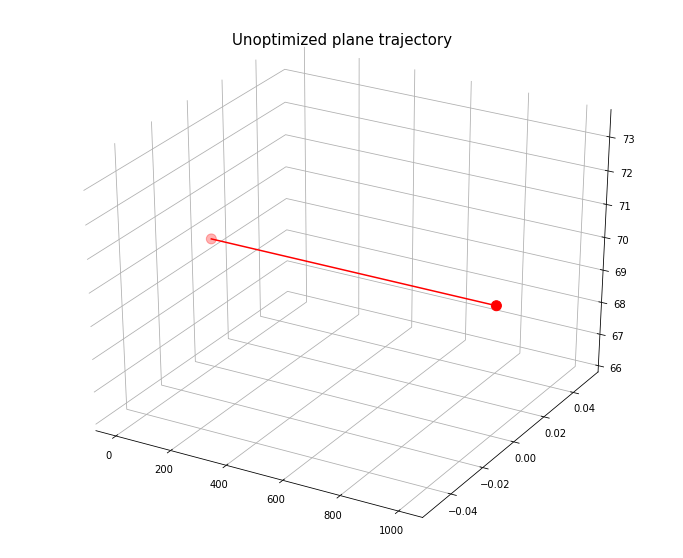

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca(projection="3d")

# Get rid of colored axes planes
# remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#set color to white
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

x,y,z = [0,1008.22744],[0,0],[69.7992,69.7992]
ax.scatter3D(x,y,z, c='r',s=100)
ax.plot(x,y,z, color='r')
plt.title(label="Unoptimized plane trajectory",
          fontsize=15)
plt.show()

In [ ]:
r_p=results2[1]
r_t = results2[3]
r_t2 = r_t[r_t['hit']==1]

Text(0.5, 0.92, 'Drop test 1 with 30 knots crosswind')

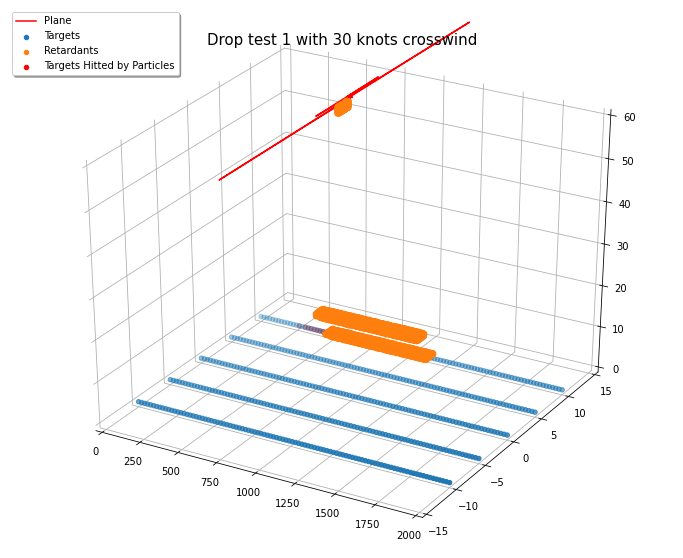

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca(projection="3d")

#Set Limit
ax.axes.set_xlim3d(left=0, right=2000) 
ax.axes.set_ylim3d(bottom=-15, top=15) 
ax.axes.set_zlim3d(bottom=0, top=60) 

# Get rid of colored axes planes
# remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#set color to white
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

#Plot Plane
# x1,y1,z1 = [30,30],[-10,10],[30,30]
# x2,y2,z2 = [40,10],[0,0],[30,30]
# x3,y3,z3 = [10,10],[-5,5],[30,30]

# ax.plot(x1,y1,z1, color='b',linewidth = 7.5, label='Plane')
# ax.plot(x2,y2,z2, color='b',linewidth = 7.5)
# ax.plot(x3,y3,z3, color='b',linewidth = 7.5)

ax.plot(plane_final[:,0], plane_final[:,1], plane_final[:,2], label='Plane', c = 'r');

#Plot Targets
ax.scatter3D(r_t['x'], r_t['y'], r_t['z'], label='Targets');

#Plot Retardants
ax.scatter3D(r_p['x'], r_p['y'], r_p['z'], label='Retardants');

#Plot targets that were hit by the particles
ax.scatter3D(r_t2['x'], r_t2['y'], r_t2['z'], c='r', marker='o', label='Targets Hitted by Particles');
ax.legend(loc='upper left', frameon=True, framealpha=1, shadow=True)
plt.title(label="Drop test 1 with 30 knots crosswind",
          fontsize=15)

In [ ]:
optimized = [88.08, 0, 0, 0, 77.51, -12.36, 55.23, 0.05, 0.25, 0.20, 0.20+9310/1120, 1.90, 0, 0, 0, 0, 35.24218]
optimized[13:16] = wind_speeds[3]
print(optimized)

[88.08, 0, 0, 0, 77.51, -12.36, 55.23, 0.05, 0.25, 0.2, 8.5125, 1.9, 0, 0, 30, 0, 35.24218]


In [ ]:
results3 = Simulation(optimized)

Num of particles:  31944
Likely no more particles left to fall
14646.0
31944
Elapsed time is 48.002453 seconds.


In [ ]:
plane = results3[-2]
plane_final = plane.GetBody()
plane_final[-2]

array([1144.47,  -12.36,   55.23])

In [ ]:
optimized[4:7]

[77.51, -12.36, 55.23]

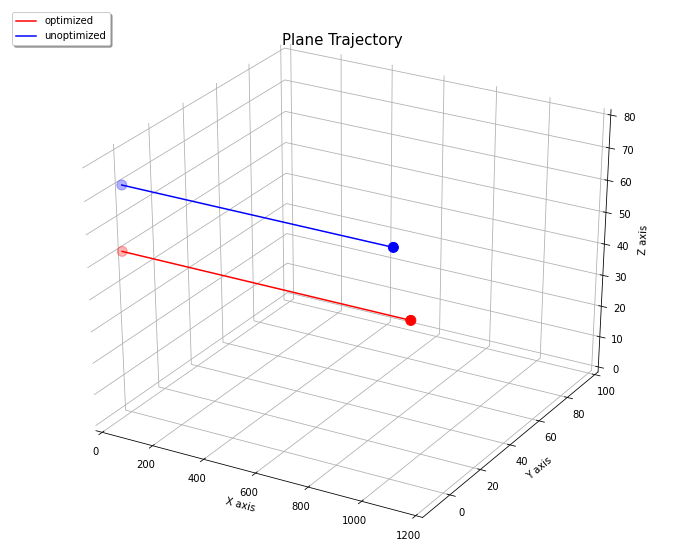

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca(projection="3d")

#Set Limit
ax.axes.set_xlim3d(left=0, right=1200) 
ax.axes.set_ylim3d(bottom=-15, top=100) 
ax.axes.set_zlim3d(bottom=0, top=80) 

# Get rid of colored axes planes
# remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#set color to white
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

#optimized
x1,y1,z1 = [77.51,1144.47],[-12.36,-12.360],[55.23, 55.23]
ax.scatter3D(x1,y1,z1, c='r',s=100)
ax.plot(x1,y1,z1, color='r', label='optimized')
#unoptimized
x,y,z = [0,1008.22744],[0,0],[69.7992,69.7992]
ax.scatter3D(x,y,z, c='b',s=100)
ax.plot(x,y,z, color='b', label='unoptimized')
plt.title(label="Plane Trajectory",
          fontsize=15)
ax.legend(loc='upper left', frameon=True, framealpha=1, shadow=True)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [ ]:
r_p=results3[1]
r_t = results3[3]
r_t2 = r_t[r_t['hit']==1]

Text(0.5, 0.92, 'Drop test 1 with 30 knots crosswind - Optimized')

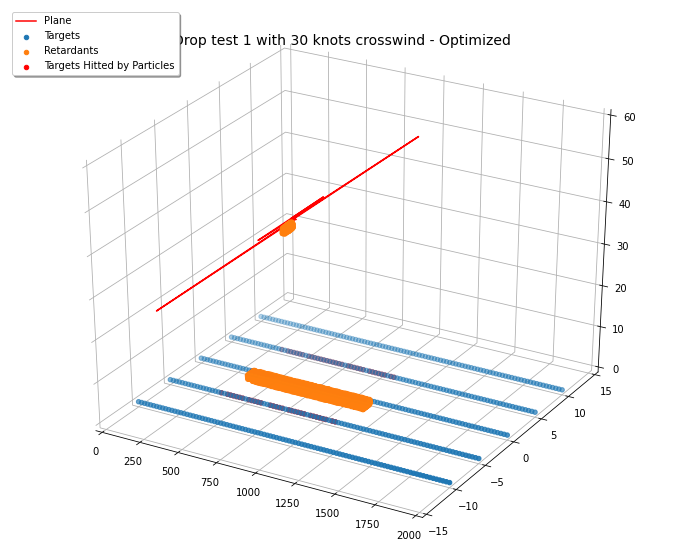

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca(projection="3d")

#Set Limit
ax.axes.set_xlim3d(left=0, right=2000) 
ax.axes.set_ylim3d(bottom=-15, top=15) 
ax.axes.set_zlim3d(bottom=0, top=60) 

# Get rid of colored axes planes
# remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

#set color to white
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

#Plot Plane
# x1,y1,z1 = [30,30],[-10,10],[30,30]
# x2,y2,z2 = [40,10],[0,0],[30,30]
# x3,y3,z3 = [10,10],[-5,5],[30,30]

# ax.plot(x1,y1,z1, color='b',linewidth = 7.5, label='Plane')
# ax.plot(x2,y2,z2, color='b',linewidth = 7.5)
# ax.plot(x3,y3,z3, color='b',linewidth = 7.5)

ax.plot(plane_final[:,0], plane_final[:,1], plane_final[:,2], label='Plane', c = 'r');

#Plot Targets
ax.scatter3D(r_t['x'], r_t['y'], r_t['z'], label='Targets');

#Plot Retardants
ax.scatter3D(r_p['x'], r_p['y'], r_p['z'], label='Retardants');

#Plot targets that were hit by the particles
ax.scatter3D(r_t2['x'], r_t2['y'], r_t2['z'], c='r', marker='o', label='Targets Hitted by Particles');
ax.legend(loc='upper left', frameon=True, framealpha=1, shadow=True)
plt.title(label="Drop test 1 with 30 knots crosswind - Optimized",
          fontsize=14)

In [ ]:
score = results2[0]
score

1.7125555555555554

In [ ]:
results = Simulation(debugging_trial)

In [ ]:
cost=results[0]
cost

In [ ]:
r_t=results[3]
r_t[r_t['hit']==1]

In [ ]:
v_p=results[2]
v_p[v_p['z']==0]

In [ ]:
r_p=results[1]
r_p[v_p['z']==0]

In [ ]:
v_p[v_p['z']==-10000].shape[0]

In [ ]:
r_t.tail()

In [ ]:
drop_13_trials = [
    [73.0511, 0, 0, 0, 0, 0, 59.7408, 0.05, 0.25, 0.5, 0.5+4683/369, 1.39682, 0, 0, 0, 0],
    [73.0511, 0, 0, 0, 0, 0, 59.7408, 0.05, 0.25, 0.25, 0.25+4683/369, 1.39682, 0, 0, 0, 0],
    [73.0511, 0, 0, 0, 0, 0, 59.7408, 0.05, 0.25, 0.2, 0.2+4683/369, 1.39682, 0, 0, 0, 0],
    [73.0511, 0, 0, 0, 0, 0, 59.7408, 0.05, 0.25, 0.10, 0.10+4683/369, 1.39682, 0, 0, 0, 0],
    [73.0511, 0, 0, 0, 0, 0, 59.7408, 0.05, 0.25, 0.05, 0.05+4683/369, 1.39682, 0, 0, 0, 0]
]